# Временные ряды 2.  Преобразование признаков

#### 1) Прочитайте базу "Потребление Энергии" и сделайте модель для сезонных изменений по data_exp_1 с горизонтом прогноза h=1 и h=10 по образцу из примера для обработки ряда "цена Нефти" . Учитывать только глубину истории при p=3.
#### 2) Оцените ошибку модели.
#### 3) Сделайте вывод о том, как изменилась ошибка модели по значениям h.

In [1]:
import numpy as np
import pandas as pd 

import matplotlib.pyplot as plt

from sklearn.ensemble import GradientBoostingRegressor

import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('my_PJME_MW.csv', index_col=[0], parse_dates=[0])
TARGET = 'PJME_MW'
data.head()

,Time,PJME_MW,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,hour,is_holiday,is_prev_holiday,is_next_holiday
Date,,,,,,,,,,,,,
2002-01-01,01:00:00,30393.0,2002,1,1,1,1,1,1,1,1,0,0
2002-01-01,02:00:00,29265.0,2002,1,1,1,1,1,1,2,1,0,0
2002-01-01,03:00:00,28357.0,2002,1,1,1,1,1,1,3,1,0,0
2002-01-01,04:00:00,27899.0,2002,1,1,1,1,1,1,4,1,0,0
2002-01-01,05:00:00,28057.0,2002,1,1,1,1,1,1,5,1,0,0


In [3]:
def exponential_smoothing(series, alpha):
    result = [series[0]]
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result

In [4]:
d_data = data.resample('D').mean()

In [5]:
b_s = pd.DataFrame(data[[TARGET]])
b_s[TARGET].rolling(window=7).mean()
b_s.head()

,PJME_MW
Date,
2002-01-01,30393.0
2002-01-01,29265.0
2002-01-01,28357.0
2002-01-01,27899.0
2002-01-01,28057.0


Text(0.5, 1.0, 'PJME_MW')

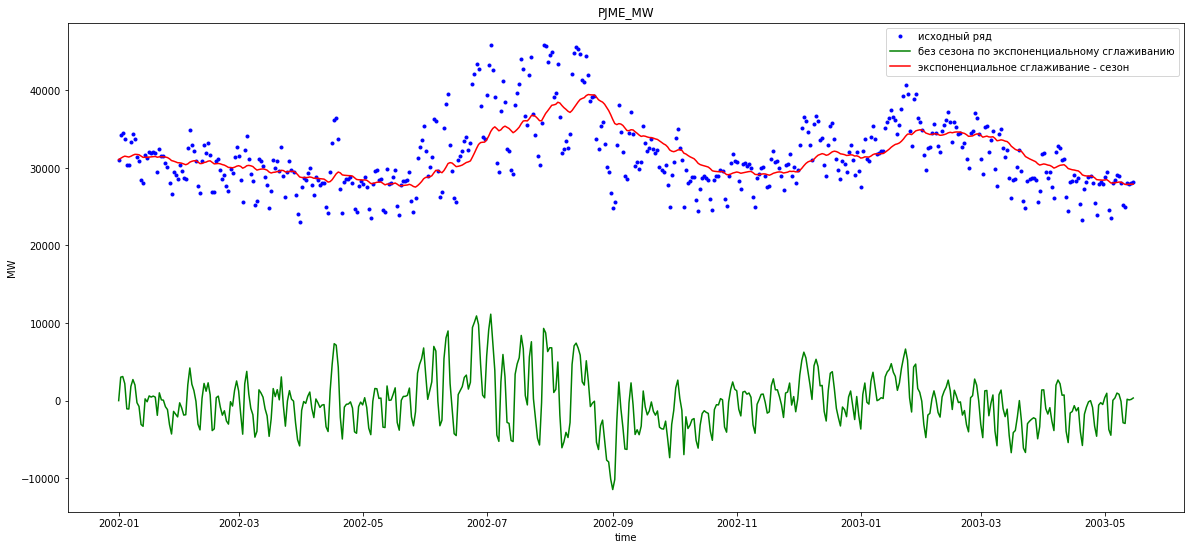

In [6]:
data_exp_1 = exponential_smoothing(d_data[TARGET], 0.05)
plt.figure(figsize=(20, 9))
plt.plot(d_data.index[:500], d_data[TARGET].values[:500], '.b', label='исходный ряд')

plt.plot(d_data.index[:500], d_data[TARGET].values[:500] - data_exp_1[:500], color='green', 
         label='без сезона по экспоненциальному сглаживанию')

plt.plot(d_data.index[:500], data_exp_1[:500], color='red', label='экспоненциальное сглаживание - сезон')

plt.xlabel('time')
plt.ylabel('MW')
plt.legend()
plt.title(TARGET)

In [7]:
df= pd.DataFrame(data_exp_1, index=d_data.index)
df.head()
 # добавили историю на глубину 3 измерения от текущего (р=3)
df['t'] = 0
df.iloc[1:, 1] = df.iloc[:-1, 0].values
df['t1'] = 0
df.iloc[2:, 2] = df.iloc[:-2, 0].values
df['t2'] = 0
df.iloc[3:, 3] = df.iloc[:-3, 0].values
df.fillna(0)
# добавили сглаживание (3 вида - просто для коллекции)
df['exp_0_01'] = exponential_smoothing(df[0], 0.01)
df['exp_0_03'] = exponential_smoothing(df[0], 0.03)
df['exp_0_08'] = exponential_smoothing(df[0], 0.08)
# добавим разности - 1-й порядок
df['diff1'] = 0
df['diff1'].iloc[1:] = df.iloc[1:, 0].values - df.iloc[:-1, 0].values

df.head()

,0,t,t1,t2,exp_0_01,exp_0_03,exp_0_08,diff1
Date,,,,,,,,
2002-01-01,31080.739130,0.000000,0.000000,0.000000,31080.739130,31080.739130,31080.739130,0.000000
2002-01-02,31239.779257,31080.739130,0.000000,0.000000,31082.329532,31085.510334,31093.462341,159.040127
2002-01-03,31403.384044,31239.779257,31080.739130,0.000000,31085.540077,31095.046546,31118.256077,163.604787
2002-01-04,31518.987759,31403.384044,31239.779257,31080.739130,31089.874554,31107.764782,31150.314611,115.603714
2002-01-05,31463.294621,31518.987759,31403.384044,31239.779257,31093.608754,31118.430677,31175.353012,-55.693138


In [8]:
def split_data_b(data, split_date):
    return data.loc[data.index.get_level_values('Date') <= split_date].copy(), \
           data.loc[data.index.get_level_values('Date') >  split_date].copy()

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def split_predict(split_date, h):
    train_b, test_b = split_data_b(df, split_date)

    X_train_b = train_b.iloc[:-h, :]
    y_train_b = train_b[df.columns[0]].values[h:]
    X_test_b = test_b.iloc[:-h, :]
    y_test_b = test_b[df.columns[0]].values[h:]

    plt.figure(figsize=(15, 5))
    plt.xlabel('Время')
    plt.ylabel('MW')
    plt.plot(train_b.index, train_b[df.columns[0]], label='Train data')
    plt.plot(test_b.index, test_b[df.columns[0]], label='Test data')
    plt.title('Тестовые и тренировочные данные')
    plt.legend()

    model_gb = GradientBoostingRegressor(max_depth=15, random_state=0, n_estimators=100)
    model_gb.fit(X_train_b, y_train_b) 
    X_test_pred_gb = model_gb.predict(X_test_b)

    plt.figure(figsize=(15, 5))

    plt.xlabel('Время')
    plt.ylabel('MW')
    plt.plot(b_s.loc[split_date:].index, b_s.loc[split_date:][TARGET], label='Исходный ряд', alpha=.2)
    plt.plot(test_b.index[h:], X_test_pred_gb, label='Предсказанный ряд')
    plt.plot(test_b.index[h:], y_test_b, label='Тестовые данные')
    plt.title(f'Предсказания при h={h}')

    plt.legend()

    er_g = mean_absolute_percentage_error(y_test_b, X_test_pred_gb)

    print(f'h={h}. Ошибка: {er_g}%')

h=1. Ошибка: 0.4429472469230937%


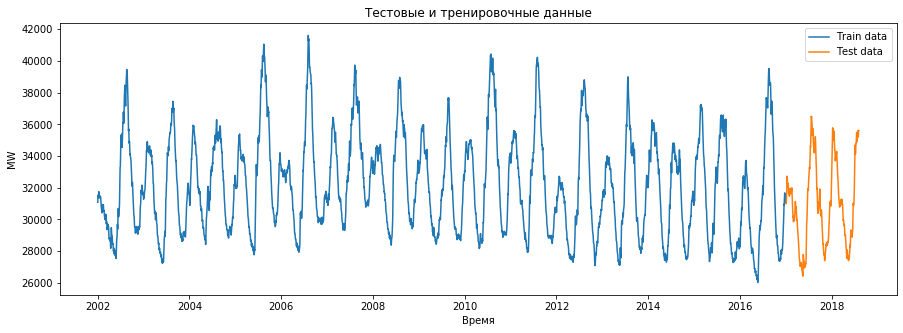

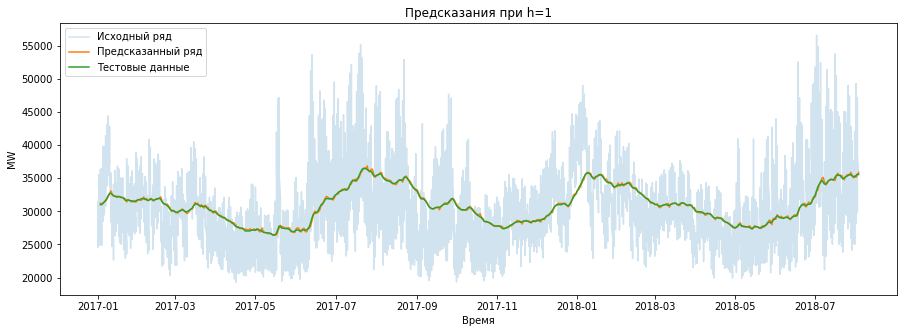

In [9]:
split_predict(split_date='01-01-2017', h=1)

Модель авторегрессии с горизонтом прогноза 1 (т.е. считаем на один шаг вперед) работает замечательно на всем интервале теста. Значение ошибки для нее не превышает 0.5%. Однако моделируем только нестационарный процесс и на коротком интервале прогноза.

h=10. Ошибка: 3.342540006930741%


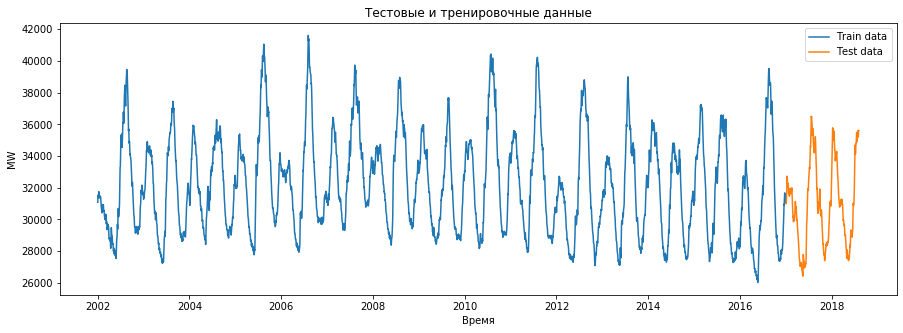

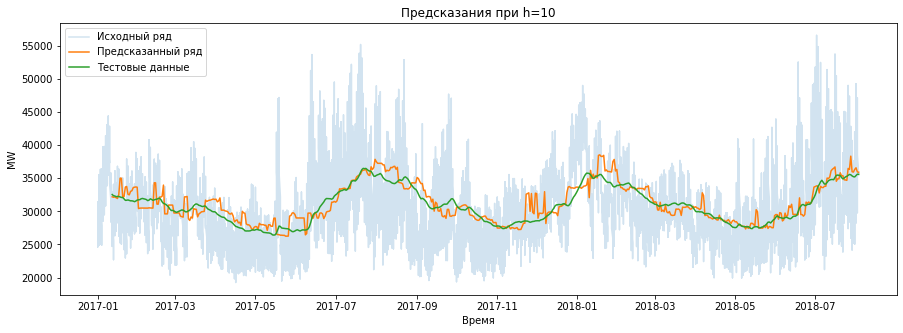

In [10]:
split_predict(split_date='01-01-2017', h=10)

Очевидно, все стало похуже (3.34% ошибки по основной линии прогноза и много по реальному ряду)

#### 4. Попробуйте предположить характер ряда (стационарный или нет, с трендом, с сезоном, с циклом) для рядов из списка и аргументируйте свой ответ (одна строка):

    а) Изменение температуры за окном :).
    
    б) Количество денег, которые тратят покупатели в интернет магазине.
    
    в) Вес растущего котенка.
    
    г) Прирост объема деревьев в лесу от времени

    а) Возможно, есть очень незначительный тренд из-за глобального потепления. Есть сезонность, времена года. Думаю, есть и циклы, какие-то года теплее в целом, какие-то холоднее с переменным периодом. 
    
    б) Думаю, есть тренд на увеличение трат из-за инфляции. Есть сезонность, когда покупают сильно больше в периоды ежегодных распродаж и перед праздниками из года в год, то есть с постоянным периодом.
    
    в) Есть тренд. Котенок растет. Сезонов и циклов, скорее всего нет.
    
    г) Наверное, есть тренд. Прирост уменьшается, так как расти деревьям все сложнее с течением времени, потому что места свободного становится меньше. Думаю есть и сезоны, и циклы. Сезоны, потому что летом весной и летом растет все лучше. Циклы, потому что бывают неурожайные года с переменным периодом.

#### 5. Какие из рядов на картинке стационарны на первый взгляд?
<img src="plots.png" width="500">

`b`, `g`, `h` похожи на стационарные